# I. Logistic Regression
In logistic regression we perform binary classification of by learnig a function of the form $f_w(x) = \sigma(x^\top w)$. Here $x,w \in \mathbb{R}^D$, where $D$ is the number of features as before. $\sigma(z) = \frac{1}{1+e^{-z}}$ is the logistic function.  Let's plot this function below

In [ ]:
import numpy as np
import pandas as pd
import time as time

#%matplotlib notebook
%matplotlib inline
import matplotlib.pyplot as plt

from IPython.core.debugger import set_trace
import warnings
warnings.filterwarnings('ignore')

In [ ]:
logistic = lambda z: 1./ (1 + np.exp(-z))  

## Cost function
To fit our model $f_w$ to the data $\mathcal{D} = \{x^{(1)}, \ldots, x^{(N)}\}$, we maximize the **logarithm of the conditional likelihood**:

$$
\ell(w; \mathcal{D}) = \sum_n \log \mathrm{Bernoulli}(y^{(n)} | \sigma({x^{(n)}}^\top w)) = \sum_n y^{(n)} \log \sigma({x^{(n)}}^\top w)) + (1-y^{(n)}) \log (1-\sigma({x^{(n)}}^\top w)))
$$

by substituting the definition of logistic function in the equation above, and minimizing the **negative** of the log-likelihood, which is called the **cost function**,
we get

$$
J(w) = \sum_n y^{(n)} \log(1+e^{-x w^\top}) + (1-y^{(n)}) \log(1+e^{x w^\top})
$$

In practice we use **mean** rather than sum over data points.

In [ ]:
def cost_fn(x, y, w):
    N, D = x.shape                                                       
    z = np.dot(x, w)
    J = np.mean(y * np.log1p(np.exp(-z)) + (1-y) * np.log1p(np.exp(z)))  #log1p calculates log(1+x) to remove floating point inaccuracies 
    return J

## Minimizing the cost using gradient descent
To minimize the cost we use gradient descent: start from some initial assignment to the parameters $w$, and at each iteration take a small step in the opposite direction of the *gradient*. The gradient of the cost function above is given by:

$$
\frac{\partial}{\partial w_d} J(w) =\sum_n - y^{(n)} x^{(n)}_d \frac{e^{-w^\top x^{(n)}}}{1 + e^{-w^\top x^{(n)}}} +x^{(n)}_d (1- y^{(n)}) \frac{e^{w^\top x^{(n)}}}{1 + e^{w^\top x^{(n)}}} = \sum_n - x^{(n)}_d y^{(n)} (1-\hat{y}^{(n)})+ x^{(n)}_d (1- y^{(n)}) \hat{y}^{(n)} = x^{(n)}_d (\hat{y}^{(n)} - y^{(n)}) 
$$
Since in practice we divide the cost by $N$, we have to the same for the gradient; see the implementation below.

In [ ]:
def gradient(self, x, y):
    N,D = x.shape
    yh = logistic(np.dot(x, self.w))    # predictions size N
    grad = np.dot(x.T, yh - y)/N        # divide by N because cost is mean over N points
    return grad                         # size D

## Logistic regression class
Now we are ready to implement the logistic regression class with the usual `fit` and `predict` methods. Here, the `fit` method implements gradient descent.

In [ ]:
def create_mini_batches(x, y, batch_size):
    mini_batches = []
    y_2d= np.reshape(y, (-1, 1))
    data = np.hstack((x, y_2d))
    n_minibatches = data.shape[0] // batch_size
    i = 0
  
    for i in range(n_minibatches + 1):
        mini_batch = data[i * batch_size:(i + 1)*batch_size, :]
        X_mini = mini_batch[:, :-1]
        Y_mini = mini_batch[:, -1].reshape((-1, 1))
        mini_batches.append((X_mini, Y_mini))
    if data.shape[0] % batch_size != 0:
        mini_batch = data[i * batch_size:data.shape[0]]
        X_mini = mini_batch[:, :-1]
        Y_mini = mini_batch[:, -1].reshape((-1, 1))
        mini_batches.append((X_mini, Y_mini))
    return mini_batches

In [ ]:
class LogisticRegression:

    def __init__(self, add_bias=True, learning_rate=.1, epsilon=1e-4, max_iters=1e5, verbose=False, batch_size=1, err_specified=0, beta=0.9):
        # The w0 term is the bias term
        self.add_bias = add_bias
        self.learning_rate = learning_rate
        # to get the tolerance for the norm of gradients 
        self.epsilon = epsilon
        # maximum number of iteration of gradient descent                        
        self.max_iters = max_iters
        # Output log text
        self.verbose = verbose
        # gradient array
        self.grad_arr = []
        # batch size
        self.batch_size = batch_size
        # Momentum coefficient
        self.beta = beta
        # The number of iterations taken 
        self.t = 0
        self.prev_g = 0
        self.err = 0
        self.err_specified = err_specified

    # The function to fit the model (Do gradient descent to find optimal vector w)
    def fit(self, x, y):
        # X here should be  a matrix, but if it has only 1 dimensional, we convert it to matrix.
        if x.ndim == 1:
            x = x[:, None]
        
        if self.add_bias:
            N = x.shape[0]
            x = np.column_stack([x,np.ones(N)])

        N,D = x.shape

        # Initialize the weight vectors with 0s
        self.w = np.zeros(D)
        self.prev_g = np.zeros(D)

        # Initialize gradient to infinity
        g = np.inf 
        
        while np.linalg.norm(g) > self.epsilon and self.t < self.max_iters:
            g = self.gradient(x, y)
            
            self.grad_arr.append(np.linalg.norm(g))
            self.prev_g = g
            
            self.w = self.w - self.learning_rate * g
            
            self.t += 1

            
        
        if self.verbose:
            print(f'terminated after {self.t} iterations, with norm of the gradient equal to {np.linalg.norm(g)}')
            # Gradient g has size=D
            print("g = " + str(g))
            print("w = " + str(self.w))

        return self
    
     # The function to fit the model with minibatch of size "batch_size"
    def fit_minibatch(self, x, y):

        # X here should be  a matrix, but if it has only 1 dimensional, we convert it to matrix.
        if x.ndim == 1:
            x = x[:, None]

        if self.add_bias:
            N = x.shape[0]
            x = np.column_stack([x,np.ones(N)])

        # Number of rows: N instance. 
        # Number of columns: D features.
        N,D = x.shape

        # Initialize the weight vectors with 0s
        self.w = np.zeros(D)
        self.prev_g = np.zeros(D)
        
        # Initialize gradient to infinity
        g = np.inf 
       
        mini_batches = create_mini_batches(x, y, self.batch_size)
        batch_index = 0

        while np.linalg.norm(g) > self.epsilon and self.t < self.max_iters and cost_fn(x,y,self.w) > self.err_specified:

            aBatch = mini_batches[batch_index]
            x_mini, y_mini = aBatch

            y_mini = y_mini.flatten()
            
            self.err = cost_fn(x,y,self.w)
            g = self.gradient(x_mini, y_mini)
            self.prev_g = g

            self.w = self.w - self.learning_rate * g 
            self.t += 1
            batch_index +=1
            if(batch_index == (len(mini_batches)-1)):
                batch_index=0
            
        
        if self.verbose:
            print(f'terminated after {self.t} iterations, with norm of the gradient equal to {np.linalg.norm(g)}')
            # Gradient g has size=D
            print("g = " + str(g))
            print("w = " + str(self.w))

        return self
    
    
    def predict(self, x):
        if x.ndim == 1:
            x = x[:, None]
        Nt = x.shape[0]
        if self.add_bias:
            x = np.column_stack([x,np.ones(Nt)])

        # The predicted result is y_hat
        yh = logistic(np.dot(x,self.w)) 
        return yh

LogisticRegression.gradient = gradient             #initialize the gradient method of the LogisticRegression class with gradient function

# II. Diabetes Experiment

We apply the logistic regression model with gradient descent on the diabetes patients data. We want to predict whether a patient has diabetes from 9 features that they have.

## 1). Load data


In [ ]:
# Read the training data from file. The headers are from the first row.
diabetes_train = pd.read_csv('./drive/MyDrive/COMP551/diabetes/diabetes_train.csv', delimiter=",", header =0, index_col=False)

# Show the first 5 instances
print(diabetes_train.shape)
diabetes_train.head()

(600, 9)


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,5,144,82,26,285,32.0,0.452,58,1
1,0,128,68,19,180,30.5,1.391,25,1
2,9,156,86,28,155,34.3,1.189,42,1
3,1,144,82,46,180,46.1,0.335,46,1
4,0,179,90,27,0,44.1,0.686,23,1


In [ ]:
# Read the validation data from file. The headers are from the first row.
diabetes_val = pd.read_csv('./drive/MyDrive/COMP551/diabetes/diabetes_val.csv', delimiter=",", header =0, index_col=False)

# Show the first 5 instances
print(diabetes_val.shape)
diabetes_val.head()

(100, 9)


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,12,140,85,33,0,37.4,0.244,41,0
1,0,108,68,20,0,27.3,0.787,32,0
2,3,74,68,28,45,29.7,0.293,23,0
3,7,129,68,49,125,38.5,0.439,43,1
4,7,133,88,15,155,32.4,0.262,37,0


In [ ]:
# Read the validation data from file. The headers are from the first row.
diabetes_test = pd.read_csv('./drive/MyDrive/COMP551/diabetes/diabetes_test.csv', delimiter=",", header =0, index_col=False)

# Show the first 5 instances
print(diabetes_test.shape)
diabetes_test.head()

(68, 9)


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,5,117,92,0,0,34.1,0.337,38,0
1,10,179,70,0,0,35.1,0.200,37,0
2,0,129,110,46,130,67.1,0.319,26,1
3,1,109,60,8,182,25.4,0.947,21,0
4,1,108,60,46,178,35.5,0.415,24,0


### See covariance among features

                          Pregnancies   Glucose  ...       Age   Outcome
Pregnancies                  1.000000  0.105370  ...  0.536766  0.227726
Glucose                      0.105370  1.000000  ...  0.276191  0.471026
BloodPressure                0.135794  0.107605  ...  0.242953  0.047664
SkinThickness               -0.072379  0.055838  ... -0.097644  0.064961
Insulin                     -0.079542  0.356400  ... -0.011463  0.160930
BMI                          0.025301  0.190370  ...  0.040474  0.283887
DiabetesPedigreeFunction    -0.047635  0.109898  ...  0.031853  0.156866
Age                          0.536766  0.276191  ...  1.000000  0.244593
Outcome                      0.227726  0.471026  ...  0.244593  1.000000

[9 rows x 9 columns]


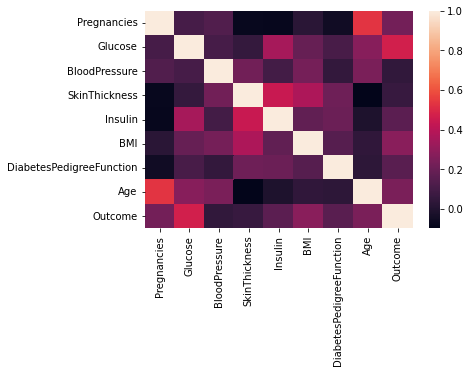

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

corr = diabetes_train.corr()
print(corr)
sns.heatmap(corr, 
         xticklabels=corr.columns, 
         yticklabels=corr.columns)

### Define features and labels

In [ ]:
#Training data
X = diabetes_train.drop(['Outcome'],1).values
y = diabetes_train['Outcome'].values

#Validation data
X_val = diabetes_val.drop(['Outcome'],1).values
y_val = diabetes_val['Outcome'].values

#Test data
X_test = diabetes_test.drop(['Outcome'],1).values
y_test = diabetes_test['Outcome'].values


### Noralmization (Optional) 

In [ ]:
means = np.mean(X, axis=0)
stds = np.std(X, axis=0)
X_norm = (X - means)/stds
X_val_norm = (X_val - means)/stds
X_test_norm = (X_test - means)/stds

print(np.mean(X, axis=0)) #=> check that new means equal 0
print(np.std(X, axis=0)) #=> check that new stds equal 1

[  3.93666667 120.805       68.83        20.25833333  77.81333333
  31.891        0.47257333  33.55166667]
[  3.37233681  32.00000482  19.0144971   16.19089036 115.65538677
   7.67570316   0.33971393  11.81202765]


### Test and show convergence

In [ ]:
#Initialize the logistic regression model with learning rate 
model = LogisticRegression(add_bias=True, learning_rate=0.0001, epsilon=1e-4, max_iters=1e5, verbose=True)

model = model.fit(X,y)

# Training accuracy
yh = np.rint(model.predict(X))
acc = (y == yh).sum() / y.size

# Validation accuracy
yh_val = np.rint(model.predict(X_val))
acc_val = (y_val == yh_val).sum() / y_val.size

# Test accuracy
yh_test = np.rint(model.predict(X_test))
acc_test = (y_test == yh_test).sum() / y_test.size

print("tain_acc = " + str(acc))
print("val_acc = " + str(acc_val))
print("test_acc = " + str(acc_test))

terminated after 100000 iterations, with norm of the gradient equal to 0.034307864937074266
g = [ 1.21397313e-04 -7.41129275e-05 -1.22501969e-04  2.07737786e-05
  9.85639110e-06 -3.37133297e-04 -6.16751736e-03 -1.00239568e-04
  3.37465828e-02]
w = [ 0.13152847  0.014274   -0.02976018 -0.00115303  0.00150239 -0.00238826
  0.06590202 -0.01156154 -0.34707329]
tain_acc = 0.7083333333333334
val_acc = 0.68
test_acc = 0.7205882352941176


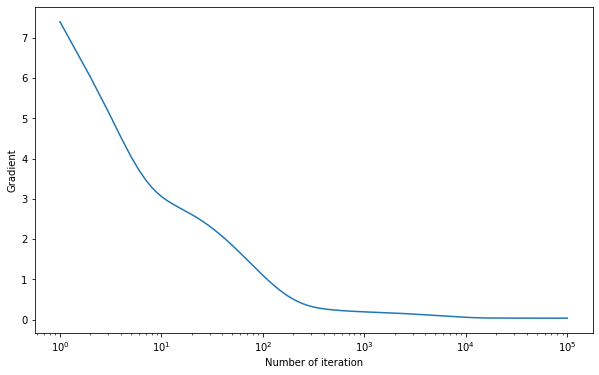

In [ ]:
# Plot the score
plt.figure(figsize=(10,6))

x = np.arange(1,100000)
plt.plot(x, model.grad_arr[1:])
ax = plt.gca()
ax.set_xscale('log')

plt.xlabel("Number of iteration")
plt.ylabel("Gradient")
plt.savefig("Gradient_converge")
plt.show()

## 2). Tune the learning rate




In [ ]:
# Specify a list of impurity decrease we want to test
best_acc = 0
best_cfg = 0
lr_list = [0.00001, 0.00005, 0.0001, 0.0005,0.001,0.005, 0.01, 0.05, 0.1, 0.5, 1, 5]
acc_list = []
val_acc_list = []

for lr in lr_list:
  #Initialize the logistic regression model with learning rate 
  model = LogisticRegression(add_bias=True, learning_rate=lr, epsilon=1e-40, max_iters=1e4, verbose=True)  

  # Predict the result on the training set
  model = model.fit(X,y)
  yh = np.rint( model.predict(X) )
  yh_val = np.rint( model.predict(X_val) )

  # Report the accuracy
  acc = (y == yh).sum() / y.size
  acc_val = (y_val == yh_val).sum() / y_val.size
  print("learning_rate = " + str(lr))
  print("accuracy = "+str(acc_val))
  print()

  acc_list.append(acc)
  val_acc_list.append(acc_val)

  # Keep track of the best accuracy and its configuation
  if acc_val > best_acc:
    best_cfg = lr
    best_acc = acc_val

print(f'best validation accuracy : {best_acc:.3f} found with learning_rate = {best_cfg}')

terminated after 10000 iterations, with norm of the gradient equal to 0.19130443252157797
g = [-1.86773322e-01  3.80443628e-04  1.12029847e-02 -1.34367936e-02
  1.10335101e-04  6.28598875e-03 -5.55000856e-03 -1.11835254e-03
  3.65422220e-02]
w = [ 0.02109884  0.01231723 -0.03025673 -0.0015395   0.00145767 -0.0055575
  0.0005087   0.00435942 -0.00378294]
learning_rate = 1e-05
accuracy = 0.64

terminated after 10000 iterations, with norm of the gradient equal to 0.1015524402100169
g = [-9.35183896e-02 -1.14596947e-03  1.28608829e-04  2.85586976e-05
 -1.23204885e-04 -6.37931959e-04 -6.32490152e-03  1.52272590e-02
  3.59664064e-02]
w = [ 0.07437811  0.01281323 -0.03057854 -0.0009706   0.00151194 -0.00593503
  0.00289471 -0.00295722 -0.01827149]
learning_rate = 5e-05
accuracy = 0.65

terminated after 10000 iterations, with norm of the gradient equal to 0.05549797321390253
g = [-4.15028977e-02 -6.19398271e-04  1.71617483e-04  2.02588017e-07
 -5.23036918e-05 -5.58185412e-04 -6.77666157e-03  6

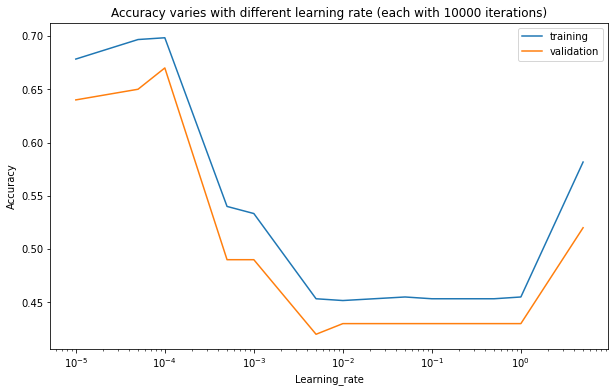

In [ ]:
# Plot the score
plt.figure(figsize=(10,6))

plt.plot(lr_list, acc_list)
plt.plot(lr_list, val_acc_list)
ax = plt.gca()
ax.set_xscale('log')

plt.xlabel("Learning_rate")
plt.ylabel("Accuracy")
plt.title("Accuracy varies with different learning rate (each with 10000 iterations)")
plt.legend(["training", "validation"])
plt.savefig("learning_rate")
plt.show()

## 3). Tune the number of iterations




In [ ]:
# Specify a list of impurity decrease we want to test
best_acc = 0
best_cfg = 0
iter_list = [100, 500, 1000, 5000, 1e4, 5e4, 1e5, 5e5, 1e6]
acc_list = []
val_acc_list = []

for iter in iter_list:

  model = LogisticRegression(add_bias=True, learning_rate=0.001, epsilon=1e-40, max_iters=iter, verbose=True)  

  # Predict the result on the training set
  model = model.fit(X,y)
  yh = np.rint( model.predict(X) )
  yh_val = np.rint( model.predict(X_val) )

  # Report the accuracy
  acc = (y == yh).sum() / y.size
  acc_val = (y_val == yh_val).sum() / y_val.size
  print("max_iteration = " + str(iter))
  print("accuracy = "+str(acc_val))
  print()

  acc_list.append(acc)
  val_acc_list.append(acc_val)

  # Keep track of the best accuracy and its configuation
  if acc_val > best_acc:
    best_cfg = iter
    best_acc = acc_val

print(f'best validation accuracy : {best_acc:.3f} found with max_iteration = {best_cfg}')

terminated after 100 iterations, with norm of the gradient equal to 67.21959093220221
g = [ -1.66806849 -47.02699664 -24.84980386  -7.67501951 -36.52369047
 -11.710799    -0.18381915 -12.50872704  -0.33021662]
w = [ 0.02383915  0.05206389 -0.08627922 -0.02308049  0.02341698 -0.00867443
  0.00045779  0.01457481 -0.00366761]
max_iteration = 100
accuracy = 0.5

terminated after 500 iterations, with norm of the gradient equal to 66.58501617198519
g = [ -1.63003244 -46.23384704 -24.84415314  -7.65511947 -36.52093215
 -11.52038145  -0.18123069 -12.28293985  -0.32377785]
w = [ 0.10386957  0.05041985 -0.09417113 -0.02095466  0.02586705 -0.00849911
  0.00253458  0.02761571 -0.01782404]
max_iteration = 500
accuracy = 0.49

terminated after 1000 iterations, with norm of the gradient equal to 66.45228112905755
g = [ -1.61721797 -46.07200221 -24.83573701  -7.64689995 -36.51828379
 -11.47940625  -0.18078746 -12.24228371  -0.32242988]
w = [ 0.18290047  0.05207662 -0.09314978 -0.02014158  0.0265444  -

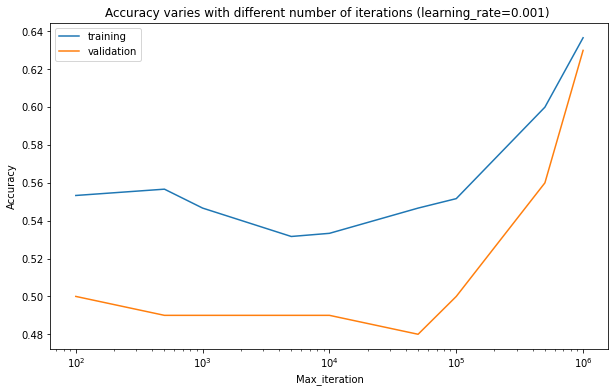

In [ ]:
# Plot the score
plt.figure(figsize=(10,6))

plt.plot(iter_list, acc_list)
plt.plot(iter_list, val_acc_list)
ax = plt.gca()
ax.set_xscale('log')

plt.xlabel("Max_iteration")
plt.ylabel("Accuracy")
plt.title("Accuracy varies with different number of iterations (learning_rate=0.001) ")
plt.legend(["training", "validation"])
plt.savefig("iteration")
plt.show()

## 4) Mini-batch stochastic gradient descent

In [ ]:
import time as time
# Specify a list of impurity decrease we want to test
best_acc = 0
best_cfg = 0
batch_list = [1, 2, 4, 8, 16, 32, 64, 128, 256, 512, 600]
acc_list = []
val_acc_list = []
time_list = []
epoch_list = []
err_list = []

for batch in batch_list:

    start_time = time.time()
    model = LogisticRegression(add_bias=True, learning_rate=0.0001, epsilon=0.0001, max_iters=3e6, verbose=True, batch_size=batch, err_specified=0.5)  
    
    # Predict the result on the training set
    model = model.fit_minibatch(X,y)
    
    yh = np.rint( model.predict(X) )
    yh_val = np.rint( model.predict(X_val) )

    temp_time = time.time() - start_time

    # Report the accuracy
    acc = (y == yh).sum() / y.size
    acc_val = (y_val == yh_val).sum() / y_val.size
    print("batch_size = " + str(batch))
    print("accuracy = "+str(acc_val))
    print("err = " + str(model.err))
    print("--- %s seconds ---" % (temp_time))
    print()

    acc_list.append(acc)
    val_acc_list.append(acc_val)
    time_list.append(temp_time)
    epoch_list.append(model.t)
    err_list.append(model.err)

    # Keep track of the best accuracy and its configuation
    if acc_val > best_acc:
        best_cfg = batch
        best_acc = acc_val

print(f'best validation accuracy : {best_acc:.3f} found with batch_size = {best_cfg}')

terminated after 2066360 iterations, with norm of the gradient equal to 45.73562047117866
g = [ 0.31695698 37.71788064 17.11567693  4.12044074 15.84784901  7.06814066
  0.06497618  7.60696752  0.31695698]
w = [ 1.97684223e-01  2.91466446e-02 -1.95596918e-02  3.55206335e-03
 -1.47114137e-03  4.59396670e-02  1.08503165e+00 -6.63908005e-03
 -5.09781791e+00]
batch_size = 1
accuracy = 0.74
err = 0.5882741343573465
--- 401.6544222831726 seconds ---

terminated after 1701534 iterations, with norm of the gradient equal to 72.93781688318316
g = [ -1.15377326 -52.14559793 -30.93385363  -8.82826631 -35.85855956
 -11.43531587  -0.12482942 -12.15767677  -0.40191977]
w = [ 1.64904106e-01  2.57734679e-02 -2.23774050e-02  2.54550260e-03
 -1.11979892e-04  3.73112091e-02  6.49168110e-01 -6.44176895e-03
 -4.19006095e+00]
batch_size = 2
accuracy = 0.75
err = 0.6634284471443584
--- 338.56606793403625 seconds ---

terminated after 1776803 iterations, with norm of the gradient equal to 20.692051431109533
g =

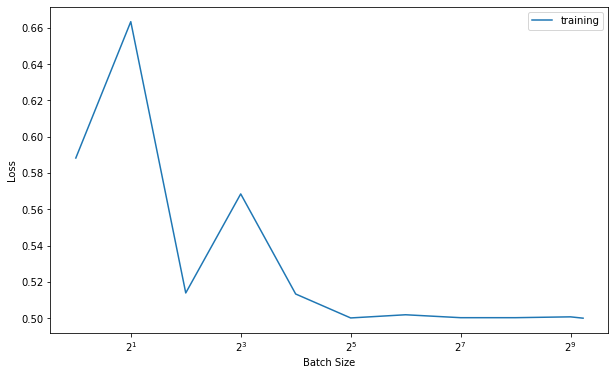

In [ ]:
# Plot the score
plt.figure(figsize=(10,6))
plt.plot(batch_list, err_list)
# plt.plot(batch_list, val_acc_list)
ax = plt.gca()
ax.set_xscale('log',basex=2)
plt.xlabel("Batch Size")
plt.ylabel("Loss")
plt.legend(["training", "validation"])
plt.savefig("batch size 1")

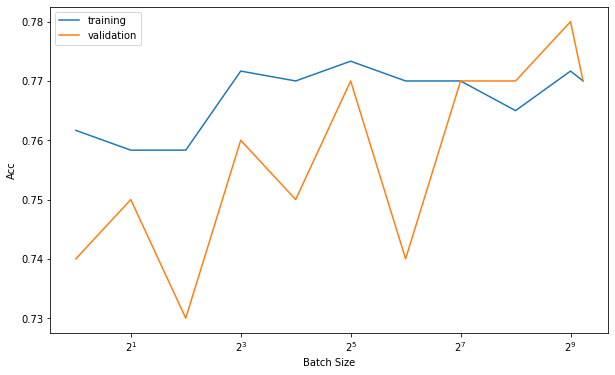

In [ ]:
# Plot the score
plt.figure(figsize=(10,6))
plt.plot(batch_list, acc_list)
plt.plot(batch_list, val_acc_list)
ax = plt.gca()
ax.set_xscale('log',basex=2)
plt.xlabel("Batch Size")
plt.ylabel("Acc")
plt.legend(["training", "validation"])
plt.savefig("batch size 2")

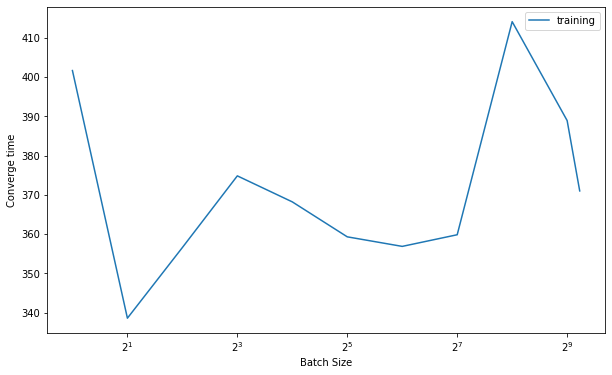

In [ ]:
# Plot the score
plt.figure(figsize=(10,6))
plt.plot(batch_list, time_list)
# plt.plot(batch_list, val_acc_list)
ax = plt.gca()
ax.set_xscale('log',basex=2)
plt.xlabel("Batch Size")
plt.ylabel("Converge time")
plt.legend(["training", "validation"])
plt.savefig("batch size 3")

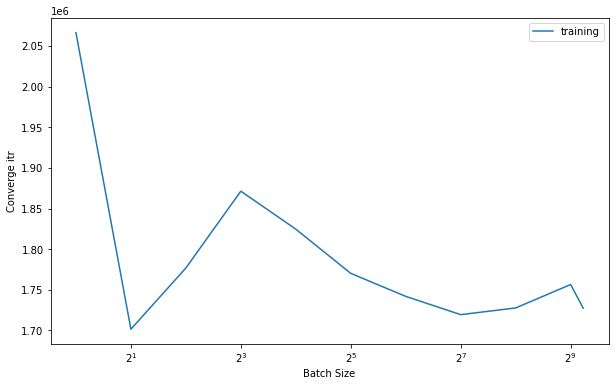

In [ ]:
# Plot the score
plt.figure(figsize=(10,6))
plt.plot(batch_list, epoch_list)
# plt.plot(batch_list, val_acc_list)
ax = plt.gca()
ax.set_xscale('log',basex=2)
plt.xlabel("Batch Size")
plt.ylabel("Converge itr")
plt.legend(["training", "validation"])
plt.savefig("batch size 4")

## 5). Gradiant descent with momentum
###**Gradient Function with Momentum**
To help with the oscillations, we use a **running average** 
of gradients and more recent gradients should have higher weights.
Then, we get the formula:

$$
dw^{[T]} = \beta dw^{[t-1]}+(1-\beta)\frac{\partial}{\partial w} J(w^{[t]})
$$

to calculate the step size for gradiant descent.




In [ ]:
def mom_gradient(self, x, y):
    N,D = x.shape
    yh = logistic(np.dot(x, self.w))    # predictions size N
    cur_grad = np.dot(x.T, yh - y)/N   # divide by N because cost is mean over N points

    grad = np.dot(self.beta, self.prev_g) + np.dot((1 - self.beta), cur_grad)

    return grad                # size D

LogisticRegression.gradient = mom_gradient

### Test different beta with regular gradient descent

In [ ]:
# Specify a list of impurity decrease we want to test
best_acc = 0
best_cfg = 0
best_itr = np.Inf
#b_list = [0.8, 0.81, 0.82, 0.83, 0.84, 0.85, 0.86, 0.87, 0.88, 0.89, 
#            0.9, 0.91, 0.92, 0.93, 0.94, 0.95, 0.96, 0.97, 0.98, 0.99]

b_list = [0, 0.2, 0.4, 0.6, 0.8, 0.9]
acc_list = []
val_acc_list = []
time_list = []
err_list = []

for b in b_list:
  start_time = time.time()
  
  model = LogisticRegression(add_bias=True, learning_rate=0.0001, epsilon=0.0001, max_iters=2e6, verbose=True, beta=b, batch_size=600, err_specified=0.55)  

  # Predict the result on the training set
  model = model.fit_minibatch(X,y)
  yh = np.rint( model.predict(X) )
  yh_val = np.rint( model.predict(X_val) )
  
  temp_time = time.time() - start_time
  
  # Report the accuracy
  acc = (y == yh).sum() / y.size
  acc_val = (y_val == yh_val).sum() / y_val.size

  print("accuracy = "+str(acc_val))
  print("beta = " + str(b))
  print("err = " + str(model.err))
  print("--- %s seconds ---" % (temp_time))
  print()

  acc_list.append(acc)
  val_acc_list.append(acc_val)
  time_list.append(model.t)
  err_list.append(model.err)

  # Keep track of the smallest number of iterations and its configuation
  if best_itr > model.t:
    best_itr = model.t
    best_cfg = b
    best_acc = acc_val

print(f'The smallest number of iterations is: {best_itr} found with beta = {best_cfg} with validation accuracy: {best_acc:.3f}')

terminated after 545229 iterations, with norm of the gradient equal to 0.02695500169379509
g = [ 4.43707389e-05 -6.79857384e-05 -7.87238456e-05  1.00494262e-05
  7.25549163e-06 -2.77779149e-04 -3.18090480e-03 -8.23813605e-05
  2.67648477e-02]
w = [ 1.27977775e-01  1.74641965e-02 -2.53626965e-02 -1.80978616e-03
  1.12665187e-03  1.12730294e-02  2.63627195e-01 -7.47357877e-03
 -1.68872744e+00]
accuracy = 0.72
beta = 0
err = 0.5500000018066595
--- 120.43315482139587 seconds ---

terminated after 545229 iterations, with norm of the gradient equal to 0.02695500786119001
g = [ 4.43707714e-05 -6.79857514e-05 -7.87238698e-05  1.00494295e-05
  7.25549337e-06 -2.77779210e-04 -3.18090570e-03 -8.23813803e-05
  2.67648538e-02]
w = [ 1.27977776e-01  1.74641952e-02 -2.53626980e-02 -1.80978609e-03
  1.12665200e-03  1.12730241e-02  2.63627174e-01 -7.47358041e-03
 -1.68872695e+00]
accuracy = 0.72
beta = 0.2
err = 0.5500000150145685
--- 120.13374781608582 seconds ---

terminated after 545229 iterations, 

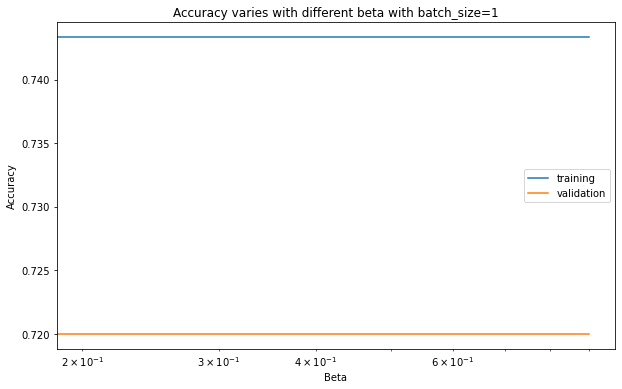

In [ ]:
# Plot the score
plt.figure(figsize=(10,6))

plt.plot(b_list, acc_list)
plt.plot(b_list, val_acc_list)
ax = plt.gca()
ax.set_xscale('log')

plt.xlabel("Beta")
plt.ylabel("Accuracy")
plt.title("Accuracy varies with different beta with batch_size=1")
plt.legend(["training", "validation"])
plt.savefig("beta_size_full")
plt.show()

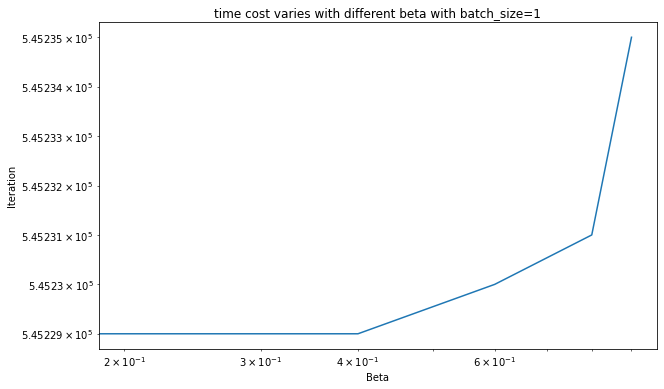

In [ ]:
# Plot the score
plt.figure(figsize=(10,6))

plt.plot(b_list, time_list)
ax = plt.gca()
ax.set_xscale('log')
ax.set_yscale('log')

plt.xlabel("Beta")
plt.ylabel("Iteration")
plt.title("time cost varies with different beta with batch_size=1")
plt.savefig("time_beta_size_full")
plt.show()

## 6). Gradient Descent with Different Batch Size and Momentum

### **Batch Size = 2**

In [ ]:
# Specify a list of impurity decrease we want to test
best_acc = 0
best_cfg = 0
best_itr = np.Inf
#b_list = [0.8, 0.81, 0.82, 0.83, 0.84, 0.85, 0.86, 0.87, 0.88, 0.89, 
#            0.9, 0.91, 0.92, 0.93, 0.94, 0.95, 0.96, 0.97, 0.98, 0.99]

b_list = [0, 0.2, 0.4, 0.6, 0.8, 0.9]
acc_list = []
val_acc_list = []
time_list = []
err_list = []

for b in b_list:
  start_time = time.time()
  
  model = LogisticRegression(add_bias=True, learning_rate=0.0001, epsilon=0.0001, max_iters=2e6, verbose=True, beta=b, batch_size=2, err_specified=0.55)  

  # Predict the result on the training set
  model = model.fit_minibatch(X,y)
  yh = np.rint( model.predict(X) )
  yh_val = np.rint( model.predict(X_val) )
  
  temp_time = time.time() - start_time
  
  # Report the accuracy
  acc = (y == yh).sum() / y.size
  acc_val = (y_val == yh_val).sum() / y_val.size

  print("accuracy = "+str(acc_val))
  print("beta = " + str(b))
  print("err = " + str(model.err))
  print("--- %s seconds ---" % (temp_time))
  print()

  acc_list.append(acc)
  val_acc_list.append(acc_val)
  time_list.append(model.t)
  err_list.append(model.err)

  # Keep track of the smallest number of iterations and its configuation
  if best_itr > model.t:
    best_itr = model.t
    best_cfg = b
    best_acc = acc_val

print(f'The smallest number of iterations is: {best_itr} found with beta = {best_cfg} with validation accuracy: {best_acc:.3f}')

terminated after 593934 iterations, with norm of the gradient equal to 75.18791943063128
g = [ -1.21349739 -54.11885499 -32.21895051  -9.29110929 -35.8645756
 -11.85394832  -0.13108619 -13.09732282  -0.41686984]
w = [ 1.60083471e-01  1.78265639e-02 -2.86186065e-02  3.22530223e-03
  1.38853470e-03  1.26710286e-02  3.59762365e-01 -1.20189357e-02
 -1.76761074e+00]
accuracy = 0.73
beta = 0
err = 0.736181275888271
--- 101.35755944252014 seconds ---

terminated after 600052 iterations, with norm of the gradient equal to 20.484509383184957
g = [ -0.56436826 -12.41515608  -7.58477881  -8.02384174 -10.64540576
  -5.34881061  -0.16637611  -1.12714237  -0.13052621]
w = [ 1.57747527e-01  1.78391528e-02 -3.04876357e-02 -3.45434746e-03
  9.09185440e-04  1.53384066e-02  3.22166993e-01 -4.81299449e-03
 -1.78464058e+00]
accuracy = 0.73
beta = 0.2
err = 0.5698567180966643
--- 102.39545392990112 seconds ---

terminated after 631852 iterations, with norm of the gradient equal to 12.489497661667407
g = [ 0

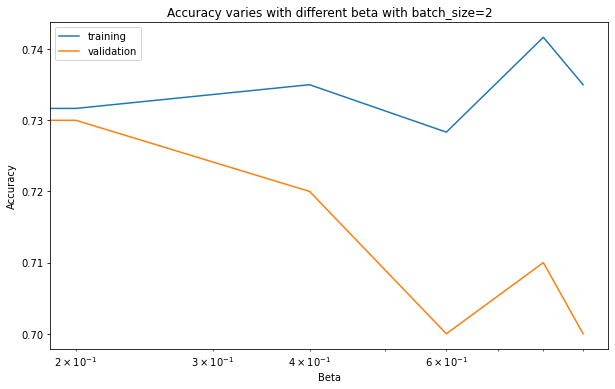

In [ ]:
# Plot the score
plt.figure(figsize=(10,6))

plt.plot(b_list, acc_list)
plt.plot(b_list, val_acc_list)
ax = plt.gca()
ax.set_xscale('log')

plt.xlabel("Beta")
plt.ylabel("Accuracy")
plt.title("Accuracy varies with different beta with batch_size=2")
plt.legend(["training", "validation"])
plt.savefig("beta_size_2")
plt.show()

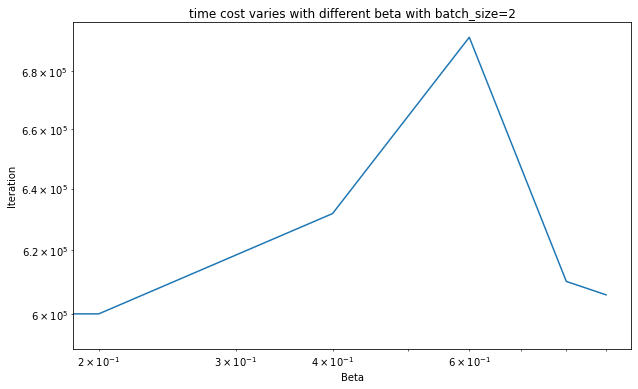

In [ ]:
# Plot the score
plt.figure(figsize=(10,6))

plt.plot(b_list, time_list)
ax = plt.gca()
ax.set_xscale('log')
ax.set_yscale('log')

plt.xlabel("Beta")
plt.ylabel("Iteration")
plt.title("time cost varies with different beta with batch_size=2")
plt.savefig("time_beta_size_2")
plt.show()

### **Largest Batch Size**

In [ ]:
# Specify a list of impurity decrease we want to test
best_acc = 0
best_cfg = 0
best_itr = np.Inf
#b_list = [0.8, 0.81, 0.82, 0.83, 0.84, 0.85, 0.86, 0.87, 0.88, 0.89, 
#            0.9, 0.91, 0.92, 0.93, 0.94, 0.95, 0.96, 0.97, 0.98, 0.99]

b_list = [0, 0.2, 0.4, 0.6, 0.8, 0.9]
acc_list = []
val_acc_list = []
time_list = []
err_list = []

for b in b_list:
  start_time = time.time()
  
  model = LogisticRegression(add_bias=True, learning_rate=0.0001, epsilon=0.0001, max_iters=2e6, verbose=True, beta=b, batch_size=512, err_specified=0.55)  

  # Predict the result on the training set
  model = model.fit_minibatch(X,y)
  yh = np.rint( model.predict(X) )
  yh_val = np.rint( model.predict(X_val) )
  
  temp_time = time.time() - start_time
  
  # Report the accuracy
  acc = (y == yh).sum() / y.size
  acc_val = (y_val == yh_val).sum() / y_val.size

  print("accuracy = "+str(acc_val))
  print("beta = " + str(b))
  print("err = " + str(model.err))
  print("--- %s seconds ---" % (temp_time))
  print()

  acc_list.append(acc)
  val_acc_list.append(acc_val)
  time_list.append(model.t)
  err_list.append(model.err)

  # Keep track of the smallest number of iterations and its configuation
  if best_itr > model.t:
    best_itr = model.t
    best_cfg = b
    best_acc = acc_val

print(f'The smallest number of iterations is: {best_itr} found with beta = {best_cfg} with validation accuracy: {best_acc:.3f}')

terminated after 565859 iterations, with norm of the gradient equal to 6.046116716128321
g = [-0.17948442 -4.42977501 -1.81722699 -0.65367151 -3.26959441 -1.17304768
 -0.02246951 -1.05069887 -0.00664871]
w = [ 1.00546266e-01  1.64746192e-02 -1.91785553e-02 -3.00443643e-04
  1.28502228e-03  2.41023089e-03  1.56251802e-01 -2.40042364e-03
 -1.78430731e+00]
accuracy = 0.73
beta = 0
err = 0.5516420970335623
--- 104.2164740562439 seconds ---

terminated after 569143 iterations, with norm of the gradient equal to 3.423005933912434
g = [-0.10819195 -2.56535164 -1.00496726 -0.36821512 -1.77464472 -0.68559875
 -0.01415138 -0.59918919  0.00748688]
w = [ 1.00031734e-01  1.63368119e-02 -1.91858534e-02 -4.96311360e-04
  1.22272800e-03  2.44690999e-03  1.67386651e-01 -2.31361752e-03
 -1.78842769e+00]
accuracy = 0.73
beta = 0.2
err = 0.5509428088791242
--- 103.85979628562927 seconds ---

terminated after 571759 iterations, with norm of the gradient equal to 1.9887498436172582
g = [-0.06550104 -1.51246

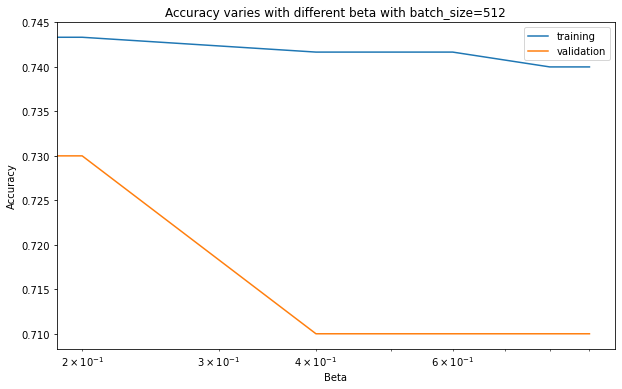

In [ ]:
# Plot the score
plt.figure(figsize=(10,6))

plt.plot(b_list, acc_list)
plt.plot(b_list, val_acc_list)
ax = plt.gca()
ax.set_xscale('log')

plt.xlabel("Beta")
plt.ylabel("Accuracy")
plt.title("Accuracy varies with different beta with batch_size=512")
plt.legend(["training", "validation"])
plt.savefig("beta_size_512")
plt.show()

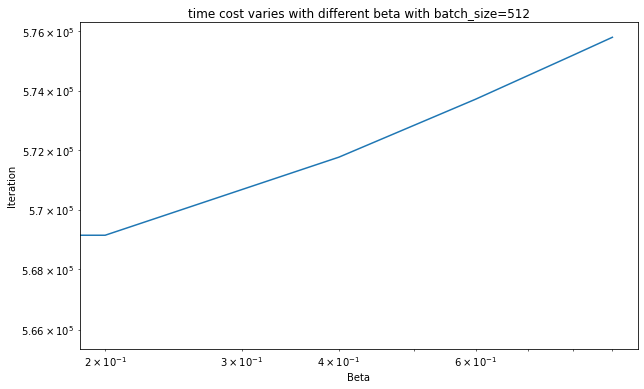

In [ ]:
# Plot the score
plt.figure(figsize=(10,6))

plt.plot(b_list, time_list)
ax = plt.gca()
ax.set_xscale('log')
ax.set_yscale('log')

plt.xlabel("Beta")
plt.ylabel("Iteration")
plt.title("time cost varies with different beta with batch_size=512")
plt.savefig("time_beta_size_512")
plt.show()

### **Smallest Batch Size: Stochastic**

In [ ]:
# Specify a list of impurity decrease we want to test
best_acc = 0
best_cfg = 0
best_itr = np.Inf
#b_list = [0.8, 0.81, 0.82, 0.83, 0.84, 0.85, 0.86, 0.87, 0.88, 0.89, 
#            0.9, 0.91, 0.92, 0.93, 0.94, 0.95, 0.96, 0.97, 0.98, 0.99]

b_list = [0, 0.2, 0.4, 0.6, 0.8, 0.9]
acc_list = []
val_acc_list = []
time_list = []
err_list = []

for b in b_list:
  start_time = time.time()
  
  model = LogisticRegression(add_bias=True, learning_rate=0.0001, epsilon=0.0001, max_iters=2e6, verbose=True, beta=b, batch_size=1, err_specified=0.55)  

  # Predict the result on the training set
  model = model.fit_minibatch(X,y)
  yh = np.rint( model.predict(X) )
  yh_val = np.rint( model.predict(X_val) )
  
  temp_time = time.time() - start_time
  
  # Report the accuracy
  acc = (y == yh).sum() / y.size
  acc_val = (y_val == yh_val).sum() / y_val.size

  print("accuracy = "+str(acc_val))
  print("beta = " + str(b))
  print("err = " + str(model.err))
  print("--- %s seconds ---" % (temp_time))
  print()

  acc_list.append(acc)
  val_acc_list.append(acc_val)
  time_list.append(model.t)
  err_list.append(model.err)

  # Keep track of the smallest number of iterations and its configuation
  if best_itr > model.t:
    best_itr = model.t
    best_cfg = b
    best_acc = acc_val

print(f'The smallest number of iterations is: {best_itr} found with beta = {best_cfg} with validation accuracy: {best_acc:.3f}')

terminated after 637181 iterations, with norm of the gradient equal to 96.2591030990413
g = [ 2.04470389 75.65404399 39.5309419  21.12860688 29.98899041 20.10625493
  0.29307422 14.9944952   0.68156796]
w = [ 1.84376426e-01  1.80560953e-02 -2.67275080e-02 -1.11723442e-03
 -7.50612998e-05  7.94807751e-03  5.87668175e-01 -7.06555774e-03
 -1.89944495e+00]
accuracy = 0.73
beta = 0
err = 0.8048835282192215
--- 105.7654447555542 seconds ---

terminated after 730184 iterations, with norm of the gradient equal to 51.933395240178086
g = [ 0.60545208 33.62864026 23.9953357  10.20400051 25.93350798 11.83982988
  0.10223452  8.54728131  0.3645327 ]
w = [ 1.86755182e-01  1.95953727e-02 -2.76608661e-02 -9.08705608e-04
  2.46912332e-03  1.21833107e-02  6.03059610e-01 -6.92914070e-03
 -2.14831163e+00]
accuracy = 0.68
beta = 0.2
err = 0.679791193110864
--- 121.63926386833191 seconds ---

terminated after 665280 iterations, with norm of the gradient equal to 38.62009822711415
g = [ -1.68884143 -30.92332

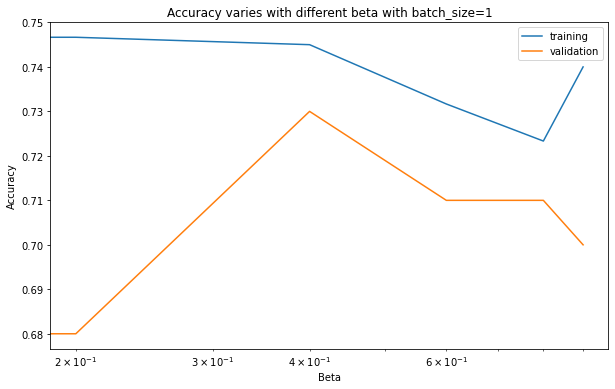

In [ ]:
# Plot the score
plt.figure(figsize=(10,6))

plt.plot(b_list, acc_list)
plt.plot(b_list, val_acc_list)
ax = plt.gca()
ax.set_xscale('log')

plt.xlabel("Beta")
plt.ylabel("Accuracy")
plt.title("Accuracy varies with different beta with batch_size=1")
plt.legend(["training", "validation"])
plt.savefig("beta_size_1")
plt.show()

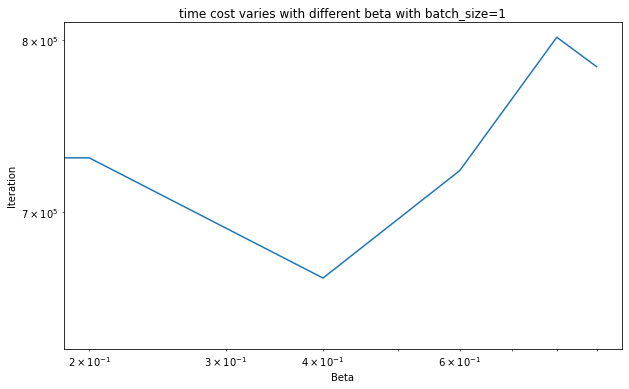

In [ ]:
# Plot the score
plt.figure(figsize=(10,6))

plt.plot(b_list, time_list)
ax = plt.gca()
ax.set_xscale('log')
ax.set_yscale('log')

plt.xlabel("Beta")
plt.ylabel("Iteration")
plt.title("time cost varies with different beta with batch_size=1")
plt.savefig("time_beta_size_1")
plt.show()

# III. Sectiont 2: Fake News


## 1). Load the data

In [ ]:
import numpy as np
import pandas as pd
from nltk.stem.snowball import SnowballStemmer
stemmer = SnowballStemmer("english")

fake_train = pd.read_csv('./drive/MyDrive/COMP551/fake_news/fake_news_train.csv', delimiter=",", header =0, index_col=False)

# Show the first 5 instances
print(fake_train.shape)
print(stemmer.stem("having"))

X = fake_train["text"].values
y = fake_train["label"].values

print(X[:5])
print(y[:5])

(20000, 2)
have
['Indian fruit is so important to so many people. Now that the season has come to an end, the first stop is to pick something fresh and tangy with some sugar.\nChopped papaya and apple is a little more complicated. And some good fats come in other sugar as well. (Milk and almonds are two great sources of fats, as well as a couple of fruits, such as avocados and okra.) The result is such a healthy, delicious apple-to-berry spread.\nEasy, Yummy and Delicious\n1 20-oz. apple or apple-livered bon bons\n2 tbsp. sugar\n1/4 tsp. almond extract\nFreshly ground black pepper\n2 tbsp. rice vinegar\n*\n6 thick and light-flavored bon bons\nSeason with salt and pepper to taste and vary thickness.\nTo finish, add the fruit to the bowl of a small mixer fitted with a large paddle attachment. Line a bowl with nonstick cooking spray. (If using spatula for these meals, add enough sugar and almond extract to shake off any excess.)\nWhen the mixture is thick and solid, remove the bowl from t

In [ ]:
fake_val = pd.read_csv('./drive/MyDrive/COMP551/fake_news/fake_news_val.csv', delimiter=",", header =0, index_col=False)

# Show the first 5 instances
print(fake_val.shape)
fake_val.head()

X_val = fake_val["text"].values
y_val= fake_val["label"].values

(2000, 2)


In [ ]:
fake_test = pd.read_csv('./drive/MyDrive/COMP551/fake_news/fake_news_test.csv', delimiter=",", header =0, index_col=False)

# Show the first 5 instances
print(fake_test.shape)
fake_test.head()

X_test = fake_test["text"].values
y_test = fake_test["label"].values

(3000, 2)


## 2). Apply the model

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import SGDClassifier


text_clf = Pipeline([
    ('vect', CountVectorizer(lowercase=False, analyzer='word', max_df=1.0, min_df=0, stop_words=None, ngram_range=(1,1), preprocessor=None)),
    ('tfidf', TfidfTransformer(norm='l2',smooth_idf=False, use_idf=True, sublinear_tf=True)),
    ('clf', SGDClassifier(penalty='l1', alpha=0, loss='hinge', max_iter=1000, verbose=1, learning_rate='adaptive', eta0=0.1))])


text_clf = text_clf.fit(X, y)

In [ ]:
# Predict the results using the model we have trained.
print("train_acc: " + str(text_clf.score(X,y)))

print("validation_acc: " + str(text_clf.score(X_val,y_val)))

print("test_acc: " + str(text_clf.score(X_test,y_test)))

train_acc: 0.9998
validation_acc: 0.7805
test_acc: 0.77


### Try different "max_df" 

In [ ]:
# Try a list of max_df
best_acc = 0
best_cfg = 0
my_list = [1.0, 0.9, 0.8, 0.7, 0.6, 0.5, 0.4, 0.3, 0.2, 0.1]
acc_list = []
# For each percentage, we train a model, do 5-fold cross validation
for item in my_list:

  text_clf = Pipeline([
    ('vect', CountVectorizer(max_df=item, min_df=0, stop_words = None, analyzer='word', ngram_range=(1, 1), preprocessor=None)),
    ('tfidf', TfidfTransformer()),
    ('clf', SGDClassifier(penalty='l2', alpha=0.00001, loss='hinge', max_iter=1000, verbose=0, learning_rate='adaptive', eta0=0.1))])
  
  text_clf = text_clf.fit(X, y)

  acc = text_clf.score(X_val,y_val)
  print("test_acc: " + str(acc))
  acc_list.append(acc)

  # Keep track of the best accuracy and its configuation
  if acc > best_acc:
    best_cfg = item
    best_acc = acc

print(f'best cross validation accuracy : {best_acc:.3f} found with percentage = {best_cfg}')

test_acc: 0.735
test_acc: 0.7223333333333334
test_acc: 0.7223333333333334
test_acc: 0.7203333333333334
test_acc: 0.7236666666666667
test_acc: 0.7186666666666667
test_acc: 0.7143333333333334
test_acc: 0.7143333333333334
test_acc: 0.7046666666666667
test_acc: 0.684
best cross validation accuracy : 0.735 found with percentage = 1.0


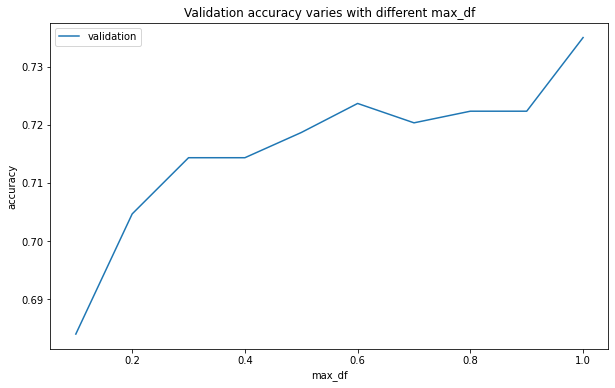

In [ ]:
# Plot the score
plt.figure(figsize=(10,6))
plt.plot(my_list, acc_list)

plt.xlabel("max_df")
plt.ylabel("accuracy")
plt.legend(["validation"])
plt.title("Validation accuracy varies with different max_df")
plt.savefig("p2-1")

### Try different "min_df"

In [ ]:
# Specify a list of percentage of data we want to work on
best_acc = 0
best_cfg = 0
my_list = [0, 0.0001, 0.001, 0.01, 0.1, 0.2, 0.5]
acc_list = []
# For each percentage, we train a model, do 5-fold cross validation
for item in my_list:

  text_clf = Pipeline([
    ('vect', CountVectorizer(max_df=1.0, min_df=item, stop_words = None, analyzer='word', ngram_range=(1, 1), preprocessor=None)),
    ('tfidf', TfidfTransformer()),
    ('clf', SGDClassifier(penalty='l2', alpha=0.00001, loss='hinge', max_iter=1000, verbose=0, learning_rate='adaptive', eta0=0.1))])
  
  text_clf = text_clf.fit(X, y)

  acc = text_clf.score(X_test,y_test)
  print("test_acc: " + str(acc))
  acc_list.append(acc)

  # Keep track of the best accuracy and its configuation
  if acc > best_acc:
    best_cfg = item
    best_acc = acc

print(f'best cross validation accuracy : {best_acc:.3f} found with percentage = {best_cfg}')

test_acc: 0.734
test_acc: 0.7343333333333333
test_acc: 0.7266666666666667
test_acc: 0.715
test_acc: 0.687
test_acc: 0.646
test_acc: 0.5903333333333334
best cross validation accuracy : 0.734 found with percentage = 0.0001


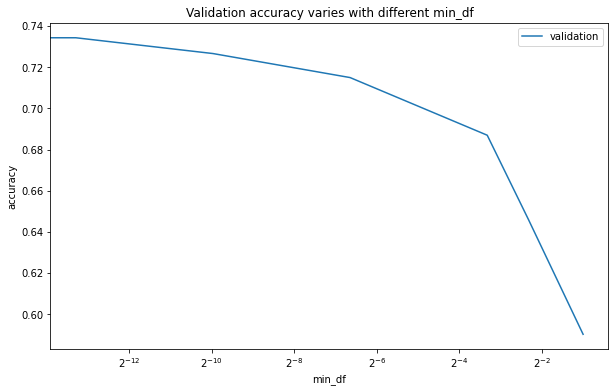

In [ ]:
# Plot the score
plt.figure(figsize=(10,6))
plt.plot(my_list, acc_list)

ax = plt.gca()
ax.set_xscale('log',basex=2)
plt.xlabel("min_df")
plt.ylabel("accuracy")
plt.legend(["validation"])
plt.title("Validation accuracy varies with different min_df")
plt.savefig("p2-2")